In [1]:
import json
import math
import random
from collections import defaultdict
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_data(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    sentences = []
    for sentence, tags in data:
        tokens = sentence.split()
        sentence_with_tags = list(zip(tokens, tags))
        sentences.append(sentence_with_tags)
    return sentences

In [3]:
def split_data(sentences, test_ratio=0.2):
    random.shuffle(sentences)
    split_idx = int(len(sentences) * (1 - test_ratio))
    return sentences[:split_idx], sentences[split_idx:]

In [4]:
def map_to_4tags(tag):
    if tag.startswith('N'):
        return 'N'
    elif tag.startswith('V'):
        return 'V'
    elif tag.startswith('JJ') or tag.startswith('RB'):
        return 'A'
    else:
        return 'O'

In [5]:
def preprocess_4tag(sentences):
    return [[(word, map_to_4tags(tag)) for (word, tag) in sentence] for sentence in sentences]


In [6]:
def train_model_b(train_sentences):
    """Train Second-Order HMM with proper trigram handling."""
    trigram_transition_counts = defaultdict(lambda: defaultdict(int))
    initial_bigram_counts = defaultdict(lambda: defaultdict(int))
    initial_unigram_counts = defaultdict(int)
    emission_counts = defaultdict(lambda: defaultdict(int))
    tag_counts = defaultdict(int)
    all_tags = set()
    all_words = set()

    for sentence in train_sentences:
        prev_prev_tag, prev_tag = None, None
        for i, (word, tag) in enumerate(sentence):
            all_tags.add(tag)
            all_words.add(word)
            tag_counts[tag] += 1
            emission_counts[tag][word] += 1

            if i == 0:
                initial_unigram_counts[tag] += 1
            elif i == 1:
                initial_bigram_counts[prev_tag][tag] += 1
            elif i >= 2:
                trigram_transition_counts[(prev_prev_tag, prev_tag)][tag] += 1

            prev_prev_tag, prev_tag = prev_tag, tag

    # Smoothing and probabilities
    num_tags = len(all_tags)
    trigram_transition_probs = defaultdict(lambda: defaultdict(lambda: -math.inf))
    for (u, v) in trigram_transition_counts:
        total = sum(trigram_transition_counts[(u, v)].values()) + num_tags
        for w in all_tags:
            count = trigram_transition_counts[(u, v)].get(w, 0) + 1
            trigram_transition_probs[(u, v)][w] = math.log(count / total)

    initial_bigram_probs = defaultdict(lambda: defaultdict(lambda: -math.inf))
    for u in initial_bigram_counts:
        total = sum(initial_bigram_counts[u].values()) + num_tags
        for v in all_tags:
            count = initial_bigram_counts[u].get(v, 0) + 1
            initial_bigram_probs[u][v] = math.log(count / total)

    initial_unigram_probs = defaultdict(lambda: -math.inf)
    total_initial = sum(initial_unigram_counts.values()) + num_tags
    for tag in all_tags:
        count = initial_unigram_counts.get(tag, 0) + 1
        initial_unigram_probs[tag] = math.log(count / total_initial)

    emission_probs = defaultdict(lambda: defaultdict(lambda: -math.inf))
    femission_probs = defaultdict(lambda: defaultdict(lambda: -math.inf))
    for tag in all_tags:
        total = tag_counts[tag] + len(all_words) + 1
        for word in all_words:
          count = emission_counts[tag].get(word, 0)
          emission_probs[tag][word] = math.log(count + 1) - math.log(total)
        emission_probs[tag]['UNK'] = math.log(1) - math.log(total)

    most_freq_tag = max(tag_counts, key=lambda k: tag_counts[k])
    return (
        initial_unigram_probs,
        initial_bigram_probs,
        trigram_transition_probs,
        emission_probs,
        most_freq_tag,
        all_tags,
        all_words
    )

In [7]:
def viterbi_b(sentence, initial_uni, initial_bi, trigram_trans, emit_probs, mft, all_tags, all_words):
    """Fixed Viterbi for Second-Order HMM."""
    words = [word for word, _ in sentence]
    n = len(words)
    if n == 0:
        return []

    # DP tables
    viterbi = [defaultdict(lambda: defaultdict(lambda: -math.inf))]
    backpointers = [defaultdict(lambda: defaultdict(lambda: None))]

    # Initialize first word
    word = words[0]
    for u in all_tags:
        emit = emit_probs[u].get(word, emit_probs[u]['UNK'])
        viterbi[0][u][u] = initial_uni[u] + emit

    # Initialize second word
    if n >= 2:
        viterbi.append(defaultdict(lambda: defaultdict(lambda: -math.inf)))
        backpointers.append(defaultdict(lambda: defaultdict(lambda: None)))
        word = words[1]
        for v in all_tags:
            emit = emit_probs[v].get(word, emit_probs[v]['UNK'])
            for u in all_tags:
                prob = viterbi[0][u][u] + initial_bi[u][v] + emit
                if prob > viterbi[1][u][v]:
                    viterbi[1][u][v] = prob
                    backpointers[1][u][v] = u

    # Recursion for remaining words
    for t in range(2, n):
        viterbi.append(defaultdict(lambda: defaultdict(lambda: -math.inf)))
        backpointers.append(defaultdict(lambda: defaultdict(lambda: None)))
        word = words[t]
        for w in all_tags:
            emit = emit_probs[w].get(word, emit_probs[w]['UNK'])
            for u in all_tags:
                for v in all_tags:
                    trigram_prob = trigram_trans[(u, v)].get(w, -math.inf)
                    prev_prob = viterbi[t-1][u][v]
                    total_prob = prev_prob + trigram_prob + emit
                    if total_prob > viterbi[t][v][w]:
                        viterbi[t][v][w] = total_prob
                        backpointers[t][v][w] = (u, v)

    # Backtracking
    best_path = []
    if n == 1:
        best_u = max(all_tags, key=lambda u: viterbi[0][u][u])
        best_path = [best_u]
    else:
        max_prob = -math.inf
        best_u, best_v = None, None
        for u in all_tags:
            for v in all_tags:
                if viterbi[-1][u][v] > max_prob:
                    max_prob = viterbi[-1][u][v]
                    best_u, best_v = u, v
        best_path = [best_u, best_v]
        for t in range(n-3, -1, -1):
            prev_u, prev_v = backpointers[t+2][best_u][best_v]
            best_path.insert(0, prev_u)
            best_u, best_v = prev_v, best_u

    return best_path[:n]  # Trim to sentence length

In [8]:
def evaluate(true_sentences, pred_sentences):
    """Compute overall and tag-wise accuracy."""
    total = correct = 0
    tag_correct = defaultdict(int)
    tag_total = defaultdict(int)
    for true, pred in zip(true_sentences, pred_sentences):
        for (_, true_tag), pred_tag in zip(true, pred):
            total += 1
            tag_total[true_tag] += 1
            if true_tag == pred_tag:
                correct += 1
                tag_correct[true_tag] += 1
    overall_acc = correct / total if total else 0
    tag_acc = {tag: tag_correct[tag]/tag_total[tag] for tag in tag_total}
    return overall_acc, tag_acc


In [9]:
json_file = 'penn-data.json'  # Replace with your JSON file path
sentences = load_data(json_file)
train_36, test_36 = split_data(sentences)
train_4 = preprocess_4tag(train_36)
test_4 = preprocess_4tag(test_36)

# Train models
(initial_uni_36, initial_bi_36, trans_36, emit_36, mft_36, tags_36, words_36) = train_model_b(train_36)
(initial_uni_4, initial_bi_4, trans_4, emit_4, mft_4, tags_4, words_4) = train_model_b(train_4)

# Predict and evaluate
preds_36 = [viterbi_b(s, initial_uni_36, initial_bi_36, trans_36, emit_36, mft_36, tags_36, words_36) for s in test_36]
preds_4 = [viterbi_b(s, initial_uni_4, initial_bi_4, trans_4, emit_4, mft_4, tags_4, words_4) for s in test_4]

acc_36, tag_acc_36 = evaluate(test_36, preds_36)
acc_4, tag_acc_4 = evaluate(test_4, preds_4)

# Print results
print("=== 36-Tag (Second-Order HMM) ===")
print(f"Overall Accuracy: {acc_36:.4f}")
print("Tag-wise Accuracy:")
for tag in sorted(tag_acc_36.keys()):
    print(f"{tag}: {tag_acc_36[tag]:.4f}")

print("\n=== 4-Tag (Second-Order HMM) ===")
print(f"Overall Accuracy: {acc_4:.4f}")
print("Tag-wise Accuracy:")
for tag in ['N', 'V', 'A', 'O']:
    print(f"{tag}: {tag_acc_4.get(tag, 0.0):.4f}")

=== 36-Tag (Second-Order HMM) ===
Overall Accuracy: 0.6721
Tag-wise Accuracy:
#: 1.0000
'': 0.0000
-LRB-: 0.3333
-RRB-: 0.2083
:: 0.6512
CC: 0.9863
CD: 0.4728
DT: 0.9436
EX: 0.0952
IN: 0.9512
JJ: 0.5151
JJR: 0.1600
JJS: 0.2400
LS: 0.0000
MD: 0.3841
NN: 0.6943
NNP: 0.6503
NNPS: 0.0233
NNS: 0.3707
PDT: 0.0000
PRP: 0.6438
PRP$: 0.7124
RB: 0.3458
RBR: 0.0000
RBS: 0.1667
RP: 0.0930
SYM: 0.0000
TO: 0.9438
VB: 0.8732
VBD: 0.7029
VBG: 0.1929
VBN: 0.4056
VBP: 0.5924
VBZ: 0.7415
WDT: 0.1789
WP: 0.2931
WP$: 0.0000
WRB: 0.3000

=== 4-Tag (Second-Order HMM) ===
Overall Accuracy: 0.8622
Tag-wise Accuracy:
N: 0.8495
V: 0.7757
A: 0.6540
O: 0.9706


0.7568171936145102
{'N': 0.7081787670022964, 'O': 0.9131853785900783, 'A': 0.48700939745715865, 'V': 0.6789284286285486}


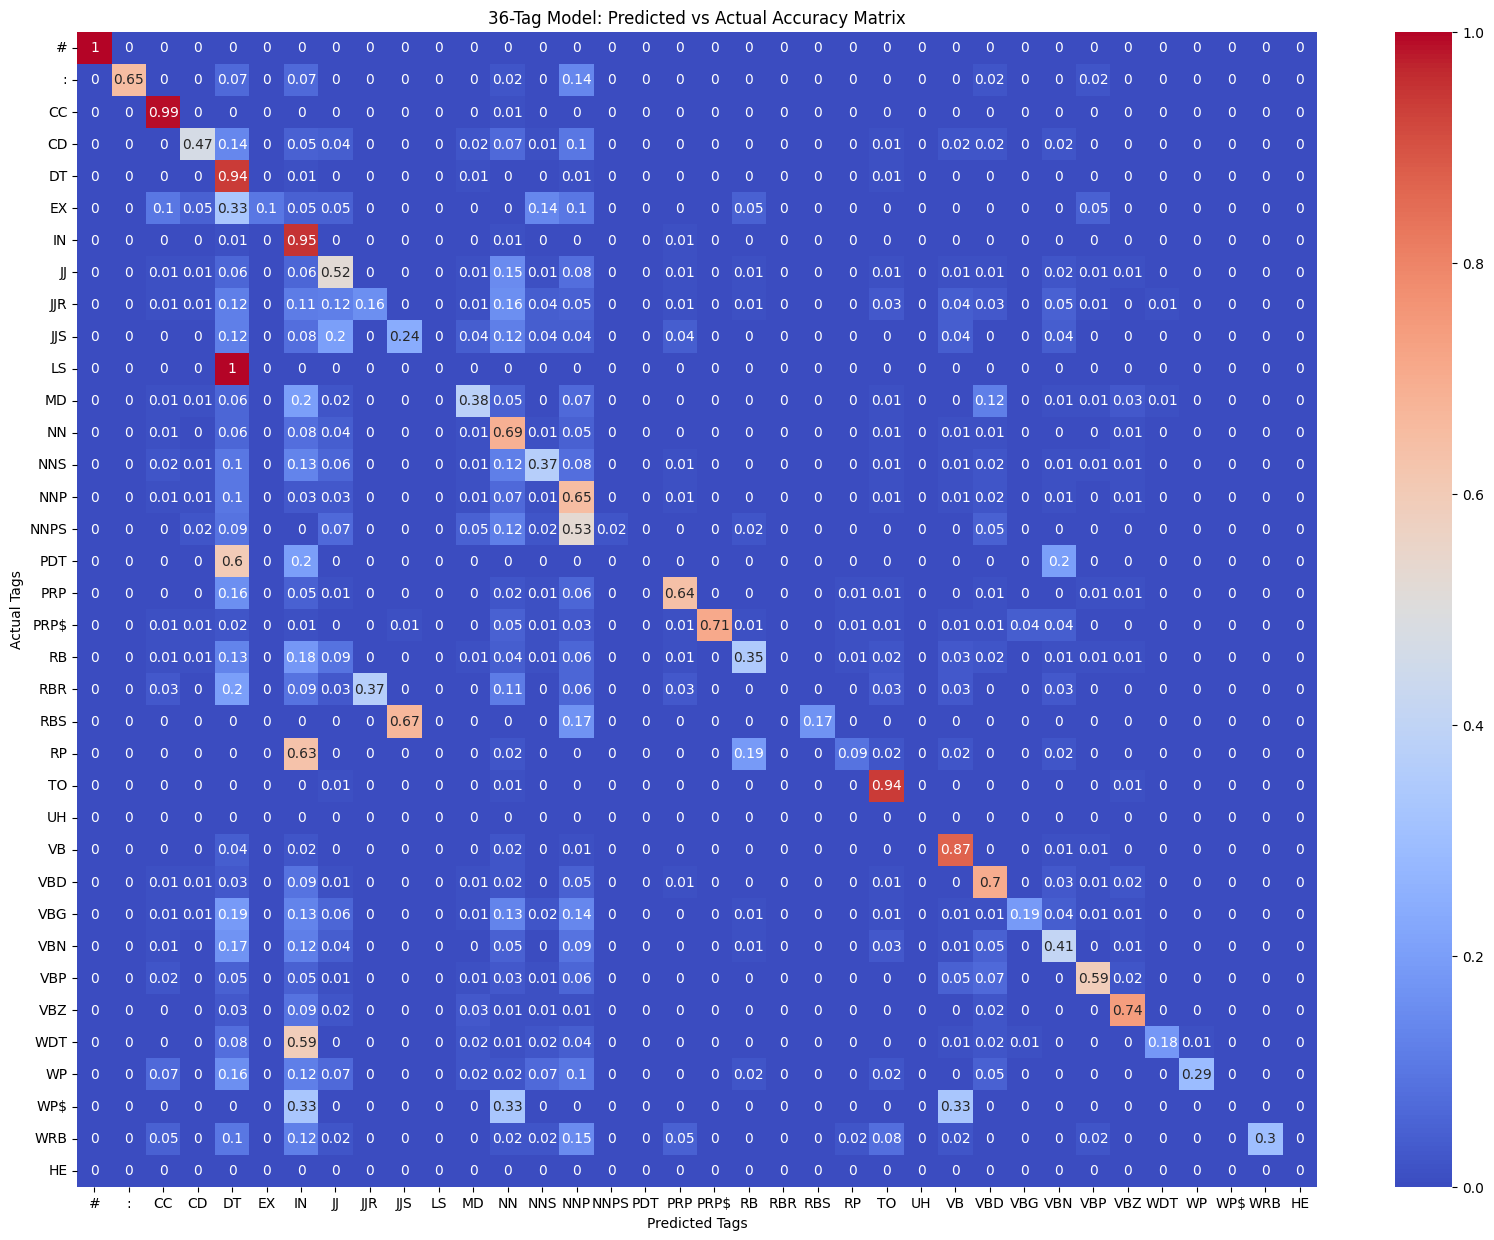

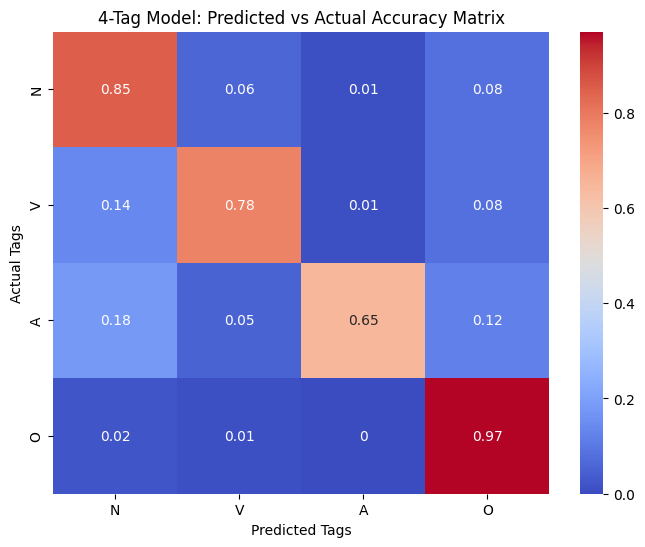

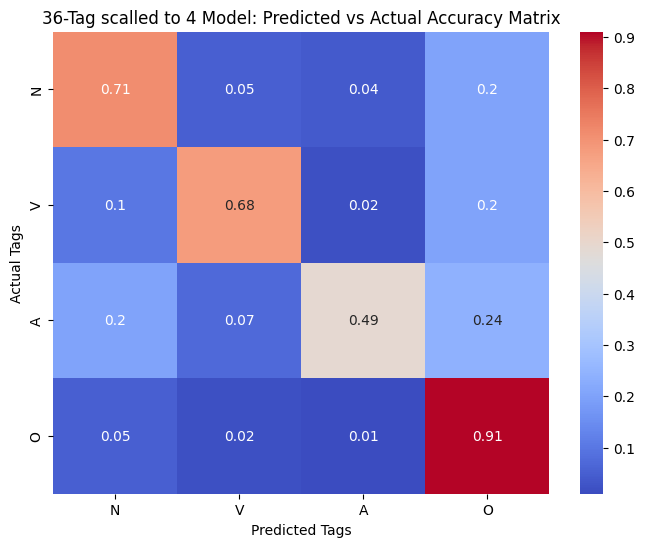

In [11]:
all_36_tags = [
    '#', ':', 'CC', 'CD', 'DT', 'EX', 'IN', 
    'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 
    'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 
    'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB','HE'
]
all_4_tags=['N', 'V', 'A', 'O']

def create_accuracy_matrix(tags, actual_data, predicted_data):
    size = len(tags)
    matrix = np.zeros((size, size))
    
    tag_index = {tag: i for i, tag in enumerate(tags)}
    # Count occurrences and mismatches
    for actual_sentence, predicted_sentence in zip(actual_data, predicted_data):
        for actual_pair, predicted_tag in zip(actual_sentence, predicted_sentence):
            actual_tag = actual_pair[1]  # Assuming actual_pair is (word, tag)
            
            if actual_tag in tags and predicted_tag in tags:
                actual_index = tag_index[actual_tag]  # Get index for the actual tag
                predicted_index = tag_index[predicted_tag]  # Get index for the predicted tag
                matrix[actual_index][predicted_index] += 1  # Increment the count

    # Normalize the matrix rows to convert counts to probabilities if needed
    row_sums = matrix.sum(axis=1, keepdims=True)
    # Check for rows where the sum is zero to avoid division by zero
    matrix = np.divide(matrix, row_sums, where=row_sums!=0)
    matrix = np.around(matrix, decimals=2)   # Avoid division by zero automatically handles by numpy

    return matrix



# Generating matrices for 36-tag and 4-tag models
matrix_36 = create_accuracy_matrix(all_36_tags, test_36, preds_36)
matrix_4 = create_accuracy_matrix(all_4_tags, test_4, preds_4)
test_mapped = [[(i[0],map_to_4tags(i[1])) for i in sent ] for sent in test_36]
pred_mapped = [[map_to_4tags(i) for i in sent ] for sent in preds_36]
matrix_36_mapped_4 = create_accuracy_matrix(all_4_tags, test_mapped, pred_mapped)
acc_maped_4,acc_tag_maped_4=evaluate(test_mapped,pred_mapped)
print(acc_maped_4)
print(acc_tag_maped_4)
# 36-Tag Model Heatmap
plt.figure(figsize=(20, 15))  # Creates a new figure with specified size
sns.heatmap(matrix_36, annot=True, cmap='coolwarm', xticklabels=all_36_tags, yticklabels=all_36_tags)
plt.title('36-Tag Model: Predicted vs Actual Accuracy Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('Actual Tags')
plt.show()  # Display the first heatmap

# 4-Tag Model Heatmap
plt.figure(figsize=(8, 6))  # Creates another new figure with specified size
sns.heatmap(matrix_4, annot=True, cmap='coolwarm', xticklabels=all_4_tags, yticklabels=all_4_tags)
plt.title('4-Tag Model: Predicted vs Actual Accuracy Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('Actual Tags')
plt.show()  # Display the second heatmap

plt.figure(figsize=(8, 6))  # Creates another new figure with specified size
sns.heatmap(matrix_36_mapped_4, annot=True, cmap='coolwarm', xticklabels=all_4_tags, yticklabels=all_4_tags)
plt.title('36-Tag scalled to 4 Model: Predicted vs Actual Accuracy Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('Actual Tags')
plt.show()

In [ ]:
def plot_accuracy(data):
    plt.figure(figsize=(8, 5))
    plt.bar(data.keys(), data.values(), color='blue')
    plt.title('Bar Plot of Given Dictionary')
    plt.xlabel('Keys')
    plt.ylabel('Values')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_accuracy(tag_acc_36)
plot_accuracy(tag_acc_4)
plot_accuracy(acc_tag_maped_4)